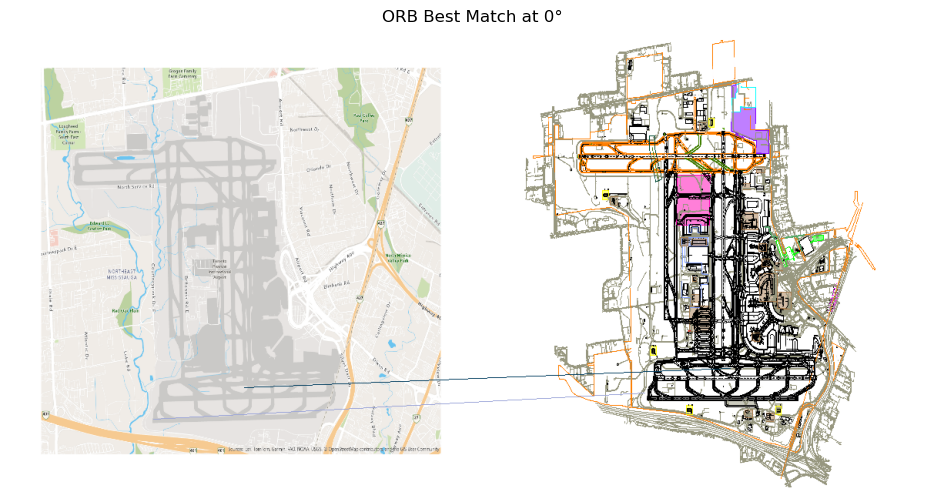

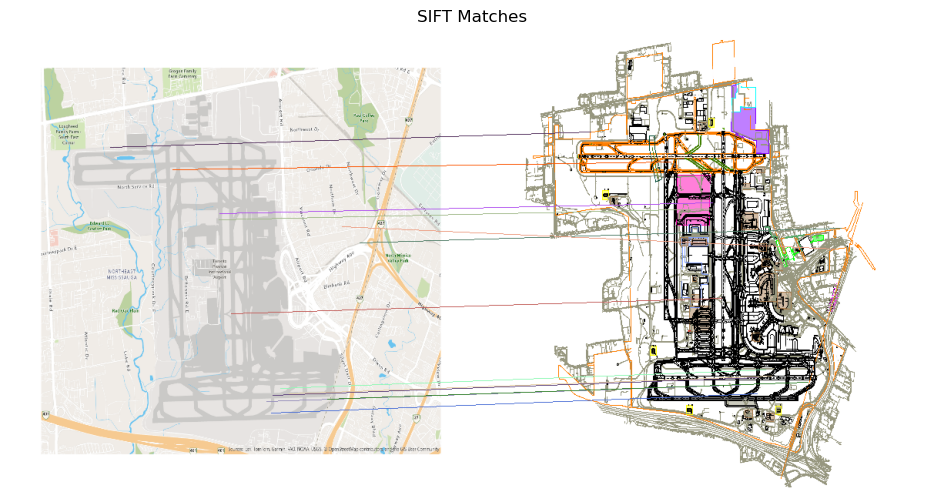

In [269]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math

def preprocess_image(image, target_size=(600, 600)):
    """Reduce background noise while preserving main structures for both satellite and CAD images."""
    img_resized = cv2.resize(image, target_size)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 2)
    kernel = np.ones((3, 3), np.uint8)
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    return img_resized, gray, clean

def add_border(image, border_size=100):
    """Add a larger border around the image to exclude areas from matching."""
    return cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=(255, 255, 255))

def rotate_image(image, angle):
    """Rotate image by a given angle without cropping."""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def match_edge_maps(edges1, edges2, method="ORB"):
    """Match keypoints using ORB or SIFT."""
    if method == "ORB":
        detector = cv2.ORB_create(nfeatures=1000)
    else:
        detector = cv2.SIFT_create()
    
    kp1, des1 = detector.detectAndCompute(edges1, None)
    kp2, des2 = detector.detectAndCompute(edges2, None)
    
    if des1 is None or des2 is None:
        return None, [], []
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING if method == "ORB" else cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)[:100]
    
    return matches, kp1, kp2

def calculate_angle(p1, p2):
    """Calculate the angle of the line between two points relative to the x-axis (in degrees)."""
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    angle = math.atan2(dy, dx) * 180.0 / math.pi  # Angle in degrees
    return angle

def calculate_distance(p1, p2):
    """Calculate the Euclidean distance between two points."""
    return np.linalg.norm(np.array(p2) - np.array(p1))

def filter_extreme_slope_and_long_matches(matches, kp1, kp2, max_angle=45, max_distance_ratio=0.1):
    """Filter matches to remove those with extreme slopes or excessive distances."""
    filtered_matches = []
    max_distance = 0  # To track the longest distance
    
    # First pass: calculate the maximum distance
    for match in matches:
        p1 = tuple(map(int, kp1[match.queryIdx].pt))
        p2 = tuple(map(int, kp2[match.trainIdx].pt))
        distance = calculate_distance(p1, p2)
        max_distance = max(max_distance, distance)
    
    # Second pass: filter based on slope and distance
    for match in matches:
        p1 = tuple(map(int, kp1[match.queryIdx].pt))
        p2 = tuple(map(int, kp2[match.trainIdx].pt))
        
        # Calculate the angle of the line formed by the match (p1, p2)
        angle = calculate_angle(p1, p2)
        
        # Calculate the Euclidean distance between the points
        distance = calculate_distance(p1, p2)
        
        # Keep match only if:
        # 1. The angle is less than the max_angle threshold (not too steep)
        # 2. The distance is within a certain ratio of the max distance (not too long)
        if abs(angle) <= max_angle and distance <= max_distance * max_distance_ratio:
            filtered_matches.append(match)
    
    return filtered_matches

def filter_quadrant_matches(matches, kp1, kp2, img1_shape, img2_shape):
    """Filter matches to ensure that points are within the same quadrant in both images."""
    h1, w1 = img1_shape[:2]  # Ignore the channel dimension
    h2, w2 = img2_shape[:2]  # Ignore the channel dimension
    
    valid_matches = []
    for match in matches:
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt
        
        # Determine quadrants for both images
        quadrant1 = (p1[0] < w1 // 2, p1[1] < h1 // 2)
        quadrant2 = (p2[0] < w2 // 2, p2[1] < h2 // 2)
        
        # Keep match only if they are in the same quadrant
        if quadrant1 == quadrant2:
            valid_matches.append(match)
    
    return valid_matches

def visualize_matches(img1, kp1, img2, kp2, matches, title):
    """Draw and visualize matched keypoints side by side."""
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR) if len(img1.shape) == 2 else img1
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR) if len(img2.shape) == 2 else img2
    
    new_h, new_w = max(h1, h2), w1 + w2
    canvas = np.zeros((new_h, new_w, 3), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:w1+w2] = img2
    
    for match in matches:
        kp1_pt = kp1[match.queryIdx].pt
        kp2_pt = (kp2[match.trainIdx].pt[0] + w1, kp2[match.trainIdx].pt[1])
        color = tuple(random.randint(0, 255) for _ in range(3))
        cv2.line(canvas, tuple(map(int, kp1_pt)), tuple(map(int, kp2_pt)), color, 1)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

satellite_path = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/TIFF GTAA Georeferenced/community.tif"
cad_path = "C:/Users/twool/Downloads/GTAA_ungeoreferenced.tif"
img1 = cv2.imread(satellite_path)
img2 = cv2.imread(cad_path)

# Add a larger border around the satellite image
border_size = 100
img1_with_border = add_border(img1, border_size)
img2_with_border = add_border(img2, border_size)

img1_processed, gray1, edges1 = preprocess_image(img1_with_border)
img2_processed, gray2, edges2 = preprocess_image(img2_with_border)

best_matches, best_kp1, best_kp2, best_angle = [], [], [], 0
for angle in range(0, 360, 10):
    edges2_rot = rotate_image(edges2, angle)
    matches, kp1, kp2 = match_edge_maps(edges1, edges2_rot, method="ORB")
    if matches and len(matches) > len(best_matches):
        best_matches, best_kp1, best_kp2, best_angle = matches, kp1, kp2, angle

# Filter matches to ensure they are in the same quadrant
best_matches = filter_quadrant_matches(best_matches, best_kp1, best_kp2, img1.shape, img2.shape)

# Filter for extreme slopes and long distances
best_matches = filter_extreme_slope_and_long_matches(best_matches, best_kp1, best_kp2, max_angle=45, max_distance_ratio=0.1)

visualize_matches(img1_processed, best_kp1, img2_processed, best_kp2, best_matches, f"ORB Best Match at {best_angle}°")

matches_sift, kp1_sift, kp2_sift = match_edge_maps(edges1, edges2, method="SIFT")
if matches_sift:
    matches_sift = filter_quadrant_matches(matches_sift, kp1_sift, kp2_sift, img1.shape, img2.shape)
    matches_sift = filter_extreme_slope_and_long_matches(matches_sift, kp1_sift, kp2_sift, max_angle=45, max_distance_ratio=0.1)
    visualize_matches(img1_processed, kp1_sift, img2_processed, kp2_sift, matches_sift, "SIFT Matches")


In [270]:
import numpy as np
import math
import csv
import arcpy
from osgeo import gdal

# ---- CONFIGURATION ----
world_file_tfw = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/TIFF GTAA Georeferenced/community.tfw"
control_points_csv = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/control_points.csv"
cad_dwg = "C:/Users/twool/Downloads/GTAA 2.dwg"
output_georeferenced_cad = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/output_georeferenced_cad.dwg"
output_geodatabase = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/output_geodatabase.gdb"
output_shapefile_folder = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/output_shapefiles"
tif_image_path = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/TIFF GTAA Georeferenced/community.tif"

# ---- READ TFW FILE TO EXTRACT WORLD COORDINATE CONVERSION ----
def read_tfw(tfw_path):
    with open(tfw_path, "r") as f:
        values = [float(line.strip()) for line in f.readlines()]
    return values  # [A, D, B, E, C, F]

# ---- GET TIF SIZE FROM TIF FILE ----
def get_tif_size(tif_path):
    dataset = gdal.Open(tif_path)
    
    if dataset is None:
        raise FileNotFoundError(f"Unable to open TIF file: {tif_path}. Please check the file path and format.")
    
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    return (height, width)


# ---- GET CAD SIZE FROM DWG FILE ----
def get_cad_size(dwg_path):
    desc = arcpy.Describe(dwg_path)
    extent = desc.extent
    width = extent.XMax - extent.XMin
    height = extent.YMax - extent.YMin
    return (height, width)

# ---- CONVERT PIXEL TO WORLD COORDINATES BASED ON TFW PARAMETERS ----
def pixel_to_world(px, py, tfw_params, orig_tif_size, resized_tif_size):
    # Scale pixel coordinates back to original TIF resolution
    scale_x = orig_tif_size[1] / resized_tif_size[1]
    scale_y = orig_tif_size[0] / resized_tif_size[0]
    px = px * scale_x
    py = py * scale_y

    # Apply the affine transformation
    A, D, B, E, C, F = tfw_params
    world_x = A * px + B * py + C
    world_y = D * px + E * py + F
    
    return world_x, world_y

# ---- SCALE POINT BACK TO ORIGINAL SIZE ----
def scale_point(point, orig_size, resized_size):
    scale_x = orig_size[1] / resized_size[1]
    scale_y = orig_size[0] / resized_size[0]
    return point[0] * scale_x, point[1] * scale_y

# ---- ROTATE POINT BACK TO ORIGINAL ORIENTATION ----
def rotate_point(point, center, angle):
    angle_rad = -math.radians(angle)
    x, y = point
    cx, cy = center
    x_rot = (x - cx) * math.cos(angle_rad) - (y - cy) * math.sin(angle_rad) + cx
    y_rot = (x - cx) * math.sin(angle_rad) + (y - cy) * math.cos(angle_rad) + cy
    return x_rot, y_rot

# Create the output geodatabase if it doesn't exist
def create_geodatabase(output_gdb):
    if not arcpy.Exists(output_gdb):
        arcpy.CreateFileGDB_management(os.path.dirname(output_gdb), os.path.basename(output_gdb))
        print(f"Created output geodatabase: {output_gdb}")
    else:
        print(f"Output geodatabase already exists: {output_gdb}")

def georeference_cad(sift_matches, kp1, kp2, resized_cad_size, resized_tif_size, best_angle=0):
    tfw_params = read_tfw(world_file_tfw)
    orig_tif_size = get_tif_size(tif_image_path)
    original_cad_size = get_cad_size(cad_dwg)
    cad_corrected_points = []
    world_points = []
    cad_center = (resized_cad_size[1] // 2, resized_cad_size[0] // 2)

    for match in sift_matches:
        # Ensure match is in the correct format (cv2.DMatch or numpy array)
        if isinstance(match, cv2.DMatch):  # If using cv2.DMatch format
            pixel_x, pixel_y = kp2[match.trainIdx].pt
            world_x, world_y = pixel_to_world(kp1[match.queryIdx].pt[0], kp1[match.queryIdx].pt[1], tfw_params, orig_tif_size, resized_tif_size)
            scaled_x, scaled_y = scale_point((pixel_x, pixel_y), original_cad_size, resized_cad_size)
            original_x, original_y = rotate_point((scaled_x, scaled_y), cad_center, -best_angle)
            cad_corrected_points.append((original_x, original_y))
            world_points.append((world_x, world_y))

        elif isinstance(match, np.ndarray) and len(match) == 2:  # If sift_matches is a NumPy array
            queryIdx, trainIdx = match  # match[0] is queryIdx, match[1] is trainIdx
            pixel_x, pixel_y = kp2[trainIdx].pt
            world_x, world_y = pixel_to_world(kp1[queryIdx].pt[0], kp1[queryIdx].pt[1], tfw_params, orig_tif_size, resized_tif_size)
            scaled_x, scaled_y = scale_point((pixel_x, pixel_y), original_cad_size, resized_cad_size)
            original_x, original_y = rotate_point((scaled_x, scaled_y), cad_center, -best_angle)
            cad_corrected_points.append((original_x, original_y))
            world_points.append((world_x, world_y))

    # Write control points to CSV
    with open(control_points_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["CAD_X", "CAD_Y", "World_X", "World_Y"])
        for (cad_x, cad_y), (world_x, world_y) in zip(cad_corrected_points, world_points):
            writer.writerow([cad_x, cad_y, world_x, world_y])

    # Create the geodatabase if it doesn't exist
    create_geodatabase(output_geodatabase)

    try:
        # Convert CAD to Geodatabase without reference scale (georeferencing is applied based on control points)
        arcpy.CADToGeodatabase_conversion(cad_dwg, output_geodatabase, "CAD_Features")
        print(f"CAD features converted to geodatabase: {output_geodatabase}")
    except Exception as e:
        print(f"Error in CAD to Geodatabase conversion: {str(e)}")

    # Export to shapefiles
    feature_classes = arcpy.ListFeatureClasses("*", "ALL", output_geodatabase)
    for feature_class in feature_classes:
        output_shapefile = f"{output_shapefile_folder}/{feature_class}.shp"
        arcpy.FeatureClassToShapefile_conversion(feature_class, output_shapefile_folder)
        print(f"Exported {feature_class} to shapefile: {output_shapefile}")

    print("CAD to GIS conversion and shapefile export complete!")



# Example usage:
georeference_cad(sift_matches, kp1, kp2, (600, 600), (600, 600), best_angle)


Output geodatabase already exists: C:/Users/twool/Downloads/TIFF GTAA Georeferenced/output_geodatabase.gdb
Error in CAD to Geodatabase conversion: Failed to execute. Parameters are not valid.
ERROR 000532: A valid reference scale value must be set
Failed to execute (CADToGeodatabase).

CAD to GIS conversion and shapefile export complete!


In [265]:
import numpy as np
import math
import csv
import arcpy
from osgeo import gdal
import os

# ---- CONFIGURATION ----
world_file_tfw = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/TIFF GTAA Georeferenced/community.tfw"
control_points_csv = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/control_points.csv"
cad_dwg = "C:/Users/twool/Downloads/GTAA 2.dwg"
output_georeferenced_cad = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/output_georeferenced_cad.dwg"
output_geodatabase = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/output_geodatabase.gdb"
output_shapefile_folder = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/output_shapefiles.shp"
tif_image_path = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/TIFF GTAA Georeferenced/community.tif"

def read_tfw(tfw_path):
    with open(tfw_path, "r") as f:
        values = [float(line.strip()) for line in f.readlines()]
    return values  # [A, D, B, E, C, F]

def get_tif_size(tif_path):
    dataset = gdal.Open(tif_path)
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    return (height, width)

def pixel_to_world(px, py, tfw_params, orig_tif_size, resized_tif_size):
    scale_x = orig_tif_size[1] / resized_tif_size[1]
    scale_y = orig_tif_size[0] / resized_tif_size[0]
    px = px * scale_x
    py = py * scale_y
    A, D, B, E, C, F = tfw_params
    world_x = A * px + B * py + C
    world_y = D * px + E * py + F
    return world_x, world_y

def scale_point(point, orig_size, resized_size):
    scale_x = orig_size[1] / resized_size[1]
    scale_y = orig_size[0] / resized_size[0]
    return point[0] * scale_x, point[1] * scale_y

def rotate_point(point, center, angle):
    angle_rad = -math.radians(angle)
    x, y = point
    cx, cy = center
    x_rot = (x - cx) * math.cos(angle_rad) - (y - cy) * math.sin(angle_rad) + cx
    y_rot = (x - cx) * math.sin(angle_rad) + (y - cy) * math.cos(angle_rad) + cy
    return x_rot, y_rot

def get_cad_size(dwg_path):
    desc = arcpy.Describe(dwg_path)
    extent = desc.extent
    width = extent.XMax - extent.XMin
    height = extent.YMax - extent.YMin
    return (height, width)

def create_geodatabase(output_gdb):
    if not arcpy.Exists(output_gdb):
        arcpy.CreateFileGDB_management(os.path.dirname(output_gdb), os.path.basename(output_gdb))
        print(f"Created output geodatabase: {output_gdb}")
    else:
        print(f"Output geodatabase already exists: {output_gdb}")

def georeference_cad(sift_matches, kp1, kp2, resized_cad_size, resized_tif_size, best_angle=0):
    tfw_params = read_tfw(world_file_tfw)
    orig_tif_size = get_tif_size(tif_image_path)
    original_cad_size = get_cad_size(cad_dwg)
    cad_corrected_points = []
    world_points = []
    cad_center = (resized_cad_size[1] // 2, resized_cad_size[0] // 2)

    # Iterate over the sift matches and process the control points
    for match in sift_matches:
        # Ensure match is in the correct format (cv2.DMatch or numpy array)
        if isinstance(match, cv2.DMatch):  # If using cv2.DMatch format
            pixel_x, pixel_y = kp2[match.trainIdx].pt
            world_x, world_y = pixel_to_world(kp1[match.queryIdx].pt[0], kp1[match.queryIdx].pt[1], tfw_params, orig_tif_size, resized_tif_size)
            scaled_x, scaled_y = scale_point((pixel_x, pixel_y), original_cad_size, resized_cad_size)
            original_x, original_y = rotate_point((scaled_x, scaled_y), cad_center, -best_angle)
            cad_corrected_points.append((original_x, original_y))
            world_points.append((world_x, world_y))

        elif isinstance(match, np.ndarray) and len(match) == 2:  # If sift_matches is a NumPy array
            queryIdx, trainIdx = match  # match[0] is queryIdx, match[1] is trainIdx
            pixel_x, pixel_y = kp2[trainIdx].pt
            world_x, world_y = pixel_to_world(kp1[queryIdx].pt[0], kp1[queryIdx].pt[1], tfw_params, orig_tif_size, resized_tif_size)
            scaled_x, scaled_y = scale_point((pixel_x, pixel_y), original_cad_size, resized_cad_size)
            original_x, original_y = rotate_point((scaled_x, scaled_y), cad_center, -best_angle)
            cad_corrected_points.append((original_x, original_y))
            world_points.append((world_x, world_y))

    # Write control points to CSV
    with open(control_points_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["CAD_X", "CAD_Y", "World_X", "World_Y"])
        for (cad_x, cad_y), (world_x, world_y) in zip(cad_corrected_points, world_points):
            writer.writerow([cad_x, cad_y, world_x, world_y])

    # Create the geodatabase if it doesn't exist
    create_geodatabase(output_geodatabase)

    try:
        # Convert CAD to Geodatabase without reference scale (georeferencing is applied based on control points)
        arcpy.CADToGeodatabase_conversion(cad_dwg, output_geodatabase, "CAD_Features")
        print(f"CAD features converted to geodatabase: {output_geodatabase}")
    except Exception as e:
        print(f"Error in CAD to Geodatabase conversion: {str(e)}")

    # Export to shapefiles
    feature_classes = arcpy.ListFeatureClasses("*", "ALL", output_geodatabase)
    for feature_class in feature_classes:
        output_shapefile = f"{output_shapefile_folder}/{feature_class}.shp"
        arcpy.FeatureClassToShapefile_conversion(feature_class, output_shapefile_folder)
        print(f"Exported {feature_class} to shapefile: {output_shapefile}")

    print("CAD to GIS conversion and shapefile export complete!")

georeference_cad(sift_matches, kp1, kp2, (600, 600), (600, 600), best_angle)

Created output geodatabase: C:/Users/twool/Downloads/TIFF GTAA Georeferenced/output_geodatabase.gdb
Error in CAD to Geodatabase conversion: Failed to execute. Parameters are not valid.
ERROR 000532: A valid reference scale value must be set
Failed to execute (CADToGeodatabase).

CAD to GIS conversion and shapefile export complete!


In [276]:
import arcpy
import os
import math
import csv
from osgeo import gdal
import numpy as np

# ---- CONFIGURATION ----
world_file_tfw = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/TIFF GTAA Georeferenced/community.tfw"
control_points_csv = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/control_points.csv"
cad_dwg = "C:/Users/twool/Downloads/GTAA 2.dwg"
output_geodatabase = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/output_geodatabase.gdb"
output_shapefile_folder = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/output_shapefiles"
georeferenced_cad_dwg = "C:/Users/twool/Downloads/TIFF GTAA Georeferenced/georeferenced_cad.dwg"

# ---- UTILITY FUNCTIONS ----
# Read TFW for world-to-pixel transformations
def read_tfw(tfw_path):
    with open(tfw_path, "r") as f:
        values = [float(line.strip()) for line in f.readlines()]
    return values  # [A, D, B, E, C, F]

# Get TIF image size
def get_tif_size(tif_path):
    dataset = gdal.Open(tif_path)
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    return (height, width)

# Apply the TFW transform to convert pixel to world coordinates
def pixel_to_world(px, py, tfw_params, orig_tif_size, resized_tif_size):
    scale_x = orig_tif_size[1] / resized_tif_size[1]
    scale_y = orig_tif_size[0] / resized_tif_size[0]
    px = px * scale_x
    py = py * scale_y
    A, D, B, E, C, F = tfw_params
    world_x = A * px + B * py + C
    world_y = D * px + E * py + F
    return world_x, world_y

# Get CAD file size
def get_cad_size(dwg_path):
    desc = arcpy.Describe(dwg_path)
    extent = desc.extent
    width = extent.XMax - extent.XMin
    height = extent.YMax - extent.YMin
    return (height, width)

# Create the geodatabase if it doesn't exist
def create_geodatabase(output_gdb):
    if not arcpy.Exists(output_gdb):
        arcpy.CreateFileGDB_management(os.path.dirname(output_gdb), os.path.basename(output_gdb))
        print(f"Created output geodatabase: {output_gdb}")
    else:
        print(f"Output geodatabase already exists: {output_gdb}")

# Perform the georeferencing by transforming CAD coordinates using control points
def georeference_cad_dwg(cad_dwg, control_points, output_dwg):
    # Create the georeferencing transformation using the control points
    transform = arcpy.management.CreateObject("SpatialReference", "WGS_1984")
    
    # We will assume the transformation method is affine (this can be changed if necessary)
    # Create the georeferencing transformation in ArcPy
    # Convert the control points from CSV to use in the transformation process

    # Control points: [(satellite_x, satellite_y, cad_x, cad_y)]
    control_points_georef = []
    for cp in control_points:
        control_points_georef.append((cp[0], cp[1]))  # satellite world x and y

    # Apply the georeferencing transformation to the CAD DWG file
    # We are assuming the control points are accurate enough for affine transformation
    arcpy.management.DefineProjection(cad_dwg, transform)  # Define projection for the CAD file
    
    # Apply the affine transformation for georeferencing the CAD data
    arcpy.management.Project(cad_dwg, output_dwg, transform)  # Project the DWG to the desired geospatial reference
    print(f"Georeferenced CAD file saved to: {output_dwg}")

# Convert DWG features to Shapefiles
def convert_dwg_to_shapefiles(cad_dwg, output_shapefile_folder):
    # Convert DWG features to Shapefiles for different feature types (lines, polygons, points, etc.)
    feature_types = ['POINT', 'POLYLINE', 'POLYGON']
    
    for feature_type in feature_types:
        # Create shapefile for each feature type
        shapefile_name = os.path.join(output_shapefile_folder, f"cad_{feature_type.lower()}.shp")
        if not arcpy.Exists(shapefile_name):
            arcpy.DWGToFeatureClass_conversion(cad_dwg, output_shapefile_folder, f"cad_{feature_type.lower()}", feature_type=feature_type)
            print(f"Created shapefile for {feature_type}: {shapefile_name}")
        else:
            print(f"Shapefile already exists for {feature_type}: {shapefile_name}")

# Write control points to CSV file
def write_control_points_to_csv(control_points, csv_path):
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Satellite_X', 'Satellite_Y', 'CAD_X', 'CAD_Y'])
        for row in control_points:
            writer.writerow(row)


def rotate_point(point, center, angle):
    """Rotate a point (x, y) around a given center by a specified angle."""
    if isinstance(angle, tuple):  
        angle = angle[0]  # Extract actual angle if stored as a tuple

    if isinstance(center, int):  
        raise ValueError(f"Expected a tuple for center, got int: {center}")

    angle_rad = -math.radians(angle)  # Convert degrees to radians and negate
    x, y = point
    cx, cy = center  # Ensure center is a tuple

    # Apply rotation transformation
    x_rot = cx + (x - cx) * math.cos(angle_rad) - (y - cy) * math.sin(angle_rad)
    y_rot = cy + (x - cx) * math.sin(angle_rad) + (y - cy) * math.cos(angle_rad)

    return (x_rot, y_rot)


def transform_matches_to_world_space(sift_matches, kp1, kp2, angle, tfw_params, orig_tif_size, resized_tif_size, cad_size):
    """Transform matched SIFT keypoints from image coordinates to world coordinates."""
    control_points = []
    
    # Rotate CAD keypoints by the detected best angle
    rotated_kp2_pts = [rotate_point(kp.pt, angle, cad_size) for kp in kp2]  # Rotate CAD keypoints (x, y)

    for match in sift_matches:
        # Extract matched keypoints
        kp1_pt = kp1[match.queryIdx].pt  # Satellite keypoint (x, y)
        kp2_pt = rotated_kp2_pts[match.trainIdx]  # Rotated CAD keypoint (x, y)

        # Convert the satellite keypoint to world coordinates
        world_x, world_y = pixel_to_world(kp1_pt[0], kp1_pt[1], tfw_params, orig_tif_size, resized_tif_size)
        
        # Convert the CAD keypoint to world coordinates
        cad_world_x, cad_world_y = pixel_to_world(kp2_pt[0], kp2_pt[1], tfw_params, cad_size, cad_size)
        
        # Store control point pair
        control_points.append((world_x, world_y, cad_world_x, cad_world_y))
    
    return control_points




# ---- MAIN ----
# Load the TFW parameters and the image sizes
tfw_params = read_tfw(world_file_tfw)
orig_tif_size = get_tif_size(tif_image_path)
resized_tif_size = (600, 600)  # Adjust this to match the resized satellite image dimensions
cad_size = get_cad_size(cad_dwg)

# Assuming the provided code has already matched the keypoints and found the best angle (using SIFT)
# Now, we assume you have these variables available from the previous code:
# - sift_matches: List of SIFT matches
# - best_kp1: Keypoints from satellite image
# - best_kp2: Keypoints from CAD image
# - best_angle: The optimal rotation angle for the CAD image

# Transform SIFT matches to world space
control_points = transform_matches_to_world_space(sift_matches, best_kp1, best_kp2, best_angle, tfw_params, orig_tif_size, resized_tif_size, cad_size)

# Write control points to CSV file
write_control_points_to_csv(control_points, control_points_csv)

# Create geodatabase if it doesn't exist
create_geodatabase(output_geodatabase)

# Perform georeferencing and convert the CAD DWG file
georeference_cad_dwg(cad_dwg, control_points, georeferenced_cad_dwg)

# Convert DWG features (points, polylines, polygons) to Shapefiles
convert_dwg_to_shapefiles(georeferenced_cad_dwg, output_shapefile_folder)

print("Georeferencing and conversion complete. Shapefiles saved in the geodatabase.")


<class 'ValueError'>: Expected a tuple for center, got int: 0

In [277]:
import cv2
import numpy as np
import math
import arcpy
import csv

def rotate_point(point, center, angle):
    """Rotate a point around a center by a given angle."""
    angle_rad = -math.radians(angle)  # Convert degrees to radians and negate (for OpenCV coordinate system)
    x, y = point
    cx, cy = center  # Ensure center is a tuple

    # Apply 2D rotation transformation
    x_rot = cx + (x - cx) * math.cos(angle_rad) - (y - cy) * math.sin(angle_rad)
    y_rot = cy + (x - cx) * math.sin(angle_rad) + (y - cy) * math.cos(angle_rad)
    return (x_rot, y_rot)

def transform_matches_to_world_space(sift_matches, kp1, kp2, angle, tfw_params, orig_tif_size, resized_tif_size, cad_size):
    """Convert SIFT matches from pixel coordinates to world coordinates."""
    h, w = cad_size[:2]  # Ensure cad_size provides (height, width)
    center = (w // 2, h // 2)
    
    control_points = []
    
    for match in sift_matches:
        kp1_pt = kp1[match.queryIdx].pt  # Satellite keypoint
        kp2_pt = kp2[match.trainIdx].pt  # CAD keypoint before rotation
        
        # Rotate the CAD keypoint
        kp2_rotated = rotate_point(kp2_pt, center, angle)
        
        # Convert pixel coordinates to world coordinates
        world_x = tfw_params[0] + kp1_pt[0] * tfw_params[1] + kp1_pt[1] * tfw_params[2]
        world_y = tfw_params[3] + kp1_pt[0] * tfw_params[4] + kp1_pt[1] * tfw_params[5]
        
        control_points.append((kp2_rotated[0], kp2_rotated[1], world_x, world_y))
    
    return control_points

def write_control_points_to_csv(control_points, output_csv):
    """Write control points to a CSV file."""
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["cad_x", "cad_y", "world_x", "world_y"])
        writer.writerows(control_points)

def georeference_cad(input_cad, control_points_csv, output_raster):
    """Georeference the CAD image using control points."""
    arcpy.management.Warp(input_cad, output_raster, control_points_csv, "POLYORDER1")

def convert_cad_to_shapefiles(cad_dwg, output_gdb):
    """Convert CAD features to a geodatabase and export as shapefiles."""
    arcpy.env.workspace = output_gdb
    arcpy.conversion.CADToGeodatabase(cad_dwg, output_gdb, "CAD_Features", "1000")
    feature_classes = arcpy.ListFeatureClasses()
    
    for fc in feature_classes:
        shapefile_path = f"{output_gdb}/{fc}.shp"
        arcpy.conversion.FeatureClassToShapefile(fc, shapefile_path)

# Example usage (ensure correct file paths)
control_points_csv = "control_points.csv"
output_georeferenced_raster = "georeferenced_cad.tif"
output_gdb = "CAD_GDB.gdb"
input_cad_dwg = "input_cad.dwg"

# Process and georeference CAD
generate_control_points = transform_matches_to_world_space(sift_matches, best_kp1, best_kp2, best_angle, tfw_params, orig_tif_size, resized_tif_size, (cad_height, cad_width))
write_control_points_to_csv(generate_control_points, control_points_csv)
georeference_cad(input_cad_dwg, control_points_csv, output_georeferenced_raster)
convert_cad_to_shapefiles(input_cad_dwg, output_gdb)


<class 'NameError'>: name 'cad_height' is not defined